# Visual Place Recognition: A Tutorial
This notebook shows a practical code example in Python that illustrates to prospective practitioners and researchers how VPR is implemented and evaluated. The example implements a basic VPR pipeline with the key steps and components that are part of most VPR pipelines.

For details or if you use our work for your academic research, please refer to the following paper:
```bibtex
@article{SchubertVisual,
    title={Visual Place Recognition: A Tutorial},
    author={Stefan Schubert and Peer Neubert and Sourav Garg and Michael Milford and Tobias Fischer},
    journal={arXiv 2303.03281},
    year={2023},
}
```

## Imports
Import the required libraries and functions.

In [1]:
from feature_extraction.feature_extractor_local import DELF
from feature_extraction.feature_extractor_holistic import AlexNetConv3Extractor
from evaluation.metrics import createPR, recallAt100precision, recallAtK
from evaluation import show_correct_and_wrong_matches
from matching import matching
from datasets.load_dataset import GardensPointDataset
import numpy as np

import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive
from IPython.display import display

from matplotlib import pyplot as plt

## Load dataset
In this example, the input to a VPR algorithm are two image sets: the database DB and query Q (i.e., multi-set VPR). For later evaluation, we also load ground-truth information about correspondences. This ground truth only serves for evaluation and will neither be available nor required when deploying the algorithm.

For demonstration, the relatively small *GardensPoint Walking* dataset with 200 images per image set is loaded. *day_right* is used as database, *night_right* as query set.

In [2]:
# load dataset GardensPoint Walking with two image sets DB (day_right) and Q (night_right) and ground truth
dataset = GardensPointDataset()
imgs_db, imgs_q, GThard, GTsoft = dataset.load()

===== Load dataset GardensPoint day_right--night_right


## Descriptor computation
The main source of information about image correspondences are image descriptors. Local descriptors like DELF provide information for multiple regions of interest but are computationally expensive to compare. Aggregation in a single holistic descriptor vector per image helps to reduce the computational complexity.

In the following, a holistic image descriptor can be selected.

In [3]:
# Widget for selecting a descriptor
def select_descriptor(Descriptor=['HDC-DELF', 'AlexNet-conv3']):
    return Descriptor
w = interactive(select_descriptor)
display(w)

interactive(children=(Dropdown(description='Descriptor', options=('HDC-DELF', 'AlexNet-conv3'), value='HDC-DEL…

In [4]:
# select descriptor
feature_extractor = None
if w.result == 'HDC-DELF':
    feature_extractor = DELF()
elif w.result == 'AlexNet-conv3':
    feature_extractor = AlexNetConv3Extractor()

# compute holistic descriptors
print('===== Compute reference set descriptors')
db_D_holistic = feature_extractor.compute_features(imgs_db)
print('===== Compute query set descriptors')
q_D_holistic = feature_extractor.compute_features(imgs_q)

2023-05-11 12:25:14.945295: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-11 12:25:14.985677: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-11 12:25:14.986265: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 12:25:15.673194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-11 12:25:18.762755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'pca_dim' with dtype int32
	 [

===== Compute reference set descriptors


  0%|          | 0/200 [00:00<?, ?it/s]

===== Compute query set descriptors


  0%|          | 0/200 [00:00<?, ?it/s]

## Descriptor comparison and similarity matrix S
To compare database and query descriptors, we can use their cosine similarity (e.g. computed by the inner product of the normalized descriptor vectors). Although we might not want to compute the full similarity matrix S of all possible pairs in a large scale practical application, it can be useful for visual inspection purposes.

Here, the *cosine similarity* between all holistic HDC-DELF descriptors is used to compute the similarity matrix S.

Text(0.5, 1.0, 'Similarity matrix S')

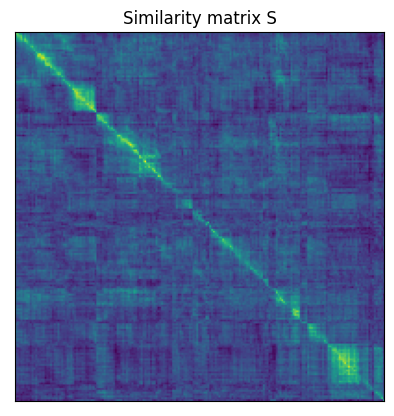

In [5]:
# compare all descriptors using cosine similarity
# normalize descriptors
db_D_holistic = db_D_holistic / np.linalg.norm(db_D_holistic , axis=1, keepdims=True)
q_D_holistic = q_D_holistic / np.linalg.norm(q_D_holistic , axis=1, keepdims=True)

# dot product between descriptors using matrix multiplication
S = np.matmul(db_D_holistic , q_D_holistic.transpose())

# show similarity matrix S
fig = plt.imshow(S)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
fig.axes.set_title('Similarity matrix S')

The image shows the similarity matrix $S{\in}\mathbb{R}^{|DB|\times|Q|}$. In the GardensPoint Walking dataset, images with the same ID were recorded at same places, i.e., the i-th database image matches the i-th query image. Therefore, we can observe high similarities along the main diagonal of S.

## Image matching
The output of a VPR pipeline is typically a set of discrete matchings, i.e. pairs of query and database images. To obtain matchings for a query image from the similarity matrix, we can either find the single best matching database image (M1) or try to find all images in the database that show the same place as the query image (M2).

Text(0.5, 1.0, 'Thresholding S>=thresh')

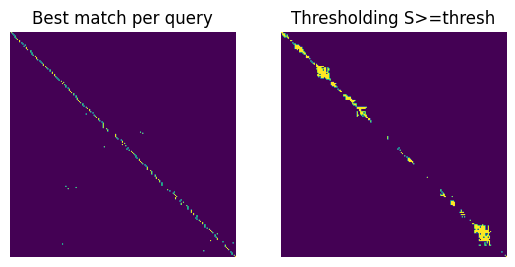

In [6]:
# best matching per query in S for single-best-match VPR
M1 = matching.best_match_per_query(S)

# find matches with S>=thresh using an auto-tuned threshold for multi-match VPR
M2 = matching.thresholding(S, 'auto')
TP = np.argwhere(M2 & GThard)  # true positives
FP = np.argwhere(M2 & ~GTsoft)  # false positives

# show M's
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(M1)
ax1.axis('off')
ax1.set_title('Best match per query')
ax2 = fig.add_subplot(122)
ax2.imshow(M2)
ax2.axis('off')
ax2.set_title('Thresholding S>=thresh')

Both matrices $M{\in}\mathbb{R}^{|DB|\times|Q|}$ show the matched images between the database and the query set. Left, only the best match per query was selected, leading to a thin line. Right, all image pairs with a similarity above a threshold were selected, s.t. we can also see multiple or no matches per query image.

Text(0.5, 1.0, 'Examples for correct and wrong matches from S>=thresh')

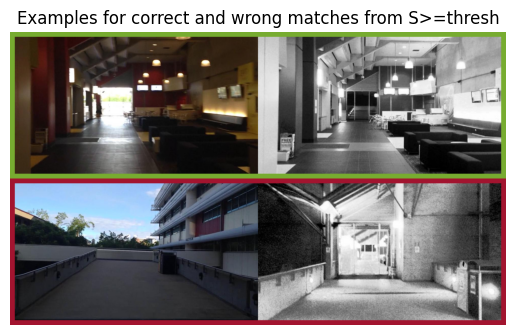

In [7]:
# show correct and wrong image matches
show_correct_and_wrong_matches.show(imgs_db, imgs_q, TP, FP)  # show random matches
plt.title('Examples for correct and wrong matches from S>=thresh')

The green frame shows a correctly matched image pair, the red frame a wrongly matched image pair.

## Evaluation
To evaluate the quality of a similarity matrix S, we can apply a series of decreasing thresholds $\theta$ to match more and more image pairs. Combined with ground-truth information, each threshold leads to a different set of true positives, false positives, true negatives and false negatives, which then provides one point on the precision-recall curve.

In the following, the precision-recall curve and the area under the precision-recall curve is computed and visualized for *multi-match VPR*, i.e. all matches between each query image and the database have to be identified.

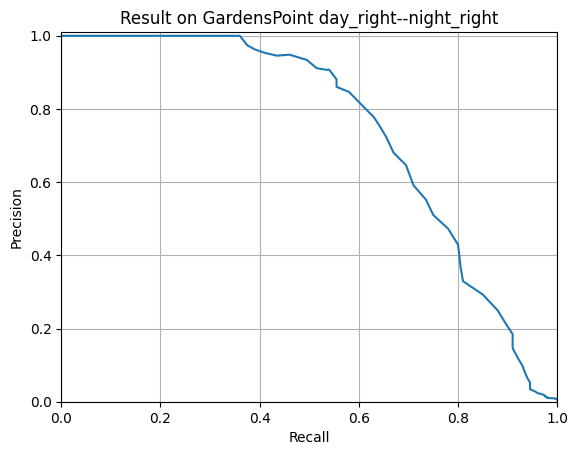

In [8]:
# precision-recall curve
P, R = createPR(S, GThard, GTsoft, matching='multi', n_thresh=100)
plt.figure()
plt.plot(R, P)
plt.xlim(0, 1), plt.ylim(0, 1.01)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Result on GardensPoint day_right--night_right')
plt.grid('on')
plt.draw()

The graph shows the precision-recall curve. A curve closer to the upper right corner would represent better performance. Precision=1 means that no false positives (FP) were extracted. A recall=1 means that all same places were found.

In [9]:
# area under precision-recall curve (AUPRC)
AUPRC = np.trapz(P, R)
print('\n===== AUPRC:', AUPRC)


===== AUPRC: 0.7419284432277942


The AUPRC performance ranges between 0 and 1 (higher is better).

In [10]:
# maximum recall at 100% precision
maxR = recallAt100precision(S, GThard, GTsoft, matching='multi', n_thresh=100)
print(f'\n===== R@100P (maximum recall at 100% precision): {maxR:.3f}')


===== R@100P (maximum recall at 100% precision): 0.360


The maximum recall at 100% precision ranges between 0 and 1 (higher is better).

In [11]:
# recall@K
Rat1 = recallAtK(S, GThard, GTsoft, K=1)
Rat5 = recallAtK(S, GThard, GTsoft, K=5)
Rat10 = recallAtK(S, GThard, GTsoft, K=10)
print(f'\n===== recall@K (R@K): R@1: {Rat1:.3f}, R@5: {Rat5:.3f}, R@10: {Rat10:.3f}')


===== recall@K (R@K): R@1: 0.850, R@5: 0.925, R@10: 0.945


The recall@K ranges between 0 and 1 (higher is better). The recall@K measures the rate of query images with at least one actually matching database image. Accordingly, the metric gets better with increasing K.